In [2]:
from FastCCM import CCM
from FastCCM.utils import utils
from FastCCM.data.data_loader import get_truncated_lorenz_rand
import numpy as np
import matplotlib.pyplot as plt
import time
import torch

### Time statistics

In [16]:

def prepare_embeddings(N_sys):
    X = np.concatenate([get_truncated_lorenz_rand(280, n_steps=30000)[:,[0]].T for _ in range(N_sys)])
    X_emb = [utils.get_td_embedding_np(x[:, None], 5, 10, return_pred=False)[:, :, 0] for x in X]
    Y_emb = [utils.get_td_embedding_np(x[:, None], 5, 10, return_pred=False)[:, [0], 0] for x in X]
    return X_emb, Y_emb

def time_ccm_computation(X_emb, Y_emb, trials=15, device="cpu"):
    
    torch.cuda.empty_cache()
    ccm = CCM.PairwiseCCM(device=device) 

    start_time = time.time()
    for _ in range(trials):
        ccm.compute(X_emb, Y_emb, 1600, 550, 30, 10, 0)
    total_time =  time.time() - start_time
    
    avg_time = total_time / trials * 1000
    time_per_pair = avg_time / len(X_emb) / len(Y_emb)
    
    return avg_time, time_per_pair


In [17]:
timeseries_counts = [1, 2, 5, 10, 15, 20, 30, 50, 100, 150, 200, 300]

In [5]:
X_emb, Y_emb = prepare_embeddings(max(timeseries_counts))

In [18]:

results_cpu = []
for count in timeseries_counts:
    avg_time, time_per_pair = time_ccm_computation(X_emb[:count], Y_emb[:count],device="cpu")
    results_cpu += [time_per_pair]
    print(f"N_sys={count}: Avg time = {avg_time:.6f}ms, Time per pair = {time_per_pair:.6f}ms")

N_sys=1: Avg time = 5.333344ms, Time per pair = 5.333344ms
N_sys=2: Avg time = 7.533805ms, Time per pair = 1.883451ms
N_sys=5: Avg time = 13.129775ms, Time per pair = 0.525191ms
N_sys=10: Avg time = 21.384748ms, Time per pair = 0.213847ms
N_sys=15: Avg time = 30.394443ms, Time per pair = 0.135086ms
N_sys=20: Avg time = 43.966627ms, Time per pair = 0.109917ms
N_sys=30: Avg time = 54.523961ms, Time per pair = 0.060582ms
N_sys=50: Avg time = 89.387560ms, Time per pair = 0.035755ms
N_sys=100: Avg time = 211.286211ms, Time per pair = 0.021129ms
N_sys=150: Avg time = 395.242039ms, Time per pair = 0.017566ms
N_sys=200: Avg time = 594.013230ms, Time per pair = 0.014850ms
N_sys=300: Avg time = 1066.944790ms, Time per pair = 0.011855ms


In [21]:

results_cuda = []
for count in timeseries_counts:
    avg_time, time_per_pair = time_ccm_computation(X_emb[:count], Y_emb[:count],device="cuda")
    results_cuda += [time_per_pair]
    print(f"N_sys={count}: Avg time = {avg_time:.6f}ms, Time per pair = {time_per_pair:.6f}ms")

N_sys=1: Avg time = 6.373103ms, Time per pair = 6.373103ms
N_sys=2: Avg time = 1.948563ms, Time per pair = 0.487141ms
N_sys=5: Avg time = 3.917742ms, Time per pair = 0.156710ms
N_sys=10: Avg time = 7.250532ms, Time per pair = 0.072505ms
N_sys=15: Avg time = 14.964453ms, Time per pair = 0.066509ms
N_sys=20: Avg time = 21.172682ms, Time per pair = 0.052932ms
N_sys=30: Avg time = 30.011876ms, Time per pair = 0.033347ms
N_sys=50: Avg time = 51.035198ms, Time per pair = 0.020414ms
N_sys=100: Avg time = 101.007303ms, Time per pair = 0.010101ms
N_sys=150: Avg time = 158.308983ms, Time per pair = 0.007036ms
N_sys=200: Avg time = 215.142266ms, Time per pair = 0.005379ms
N_sys=300: Avg time = 283.320904ms, Time per pair = 0.003148ms


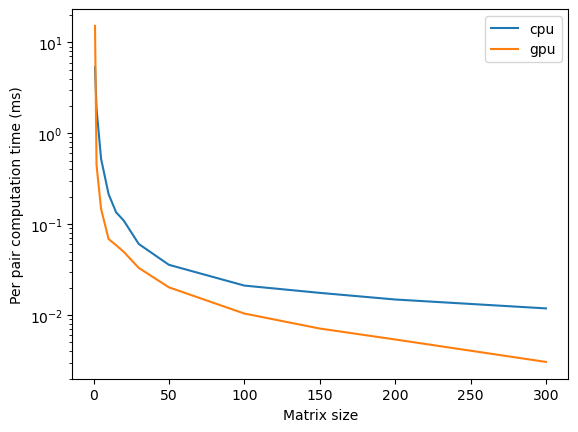

In [20]:
plt.plot(timeseries_counts, results_cpu, label="cpu")
plt.plot(timeseries_counts, results_cuda, label="gpu")
plt.yscale("log")
plt.xlabel("Matrix size")
plt.ylabel("Per pair computation time (ms)")
plt.legend()

In [10]:
torch.cuda.get_device_name()

'NVIDIA RTX 3500 Ada Generation Laptop GPU'